In [1]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
    
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from smt.explainability_tools import (
    ShapFeatureImportanceDisplay, 
    ShapDisplay,
    PartialDependenceDisplay, 
    PDFeatureImportanceDisplay, 
    PDFeatureInteractionDisplay
)
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import time


In [2]:
# Objective function
def cantilever_deflection(x):
    norm_inertia_vals = [
        0.0833, 0.139, 0.380, 0.0796,
        0.133, 0.363, 0.0859, 0.136,
        0.360, 0.0922, 0.138, 0.369,
    ]
    # norm_inertia_vals = [
    #     1.5, 0.139, 0.380, 0.0796,
    #     0.133, 0.363, 0.0859, 0.136,
    #     0.360, 0.0922, 0.138, 0.369,
    # ]
    
    I = int(x[0])
    L = x[1]
    S = x[2]
    norm_inertia = norm_inertia_vals[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * norm_inertia)

    return y

def cantilever_deflection_vectorized(X):
    y = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y[i] = cantilever_deflection(X[i, :])
    return y

In [3]:
%%time
"""Problem definition"""
# Design space
ds = DesignSpace([
    CategoricalVariable([
        "type_A", "type_B", "type_C", "type_D", 
        "type_E", "type_F", "type_G", "type_H", 
        "type_I", "type_J", "type_K", "type_L",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
categorical_feature_idx = [0]

f_obj = cantilever_deflection

# Create training and testing data
n_data = 1000
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)

# Name of the features
feature_names = [r'$I$', r'$L$', r'$S$']

# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_idx:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for value, i in enumerate(ds._design_variables[feature_idx].values)
    }

CPU times: user 6.16 s, sys: 174 ms, total: 6.34 s
Wall time: 6.34 s


In [4]:
class GroundTruthModel:
    def predict_values(self, X):
        return cantilever_deflection_vectorized(X)
    
sm = GroundTruthModel()
start_time = time.time()
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

    

RMSE: 0.0000
rRMSE: 0.0000


In [5]:
# from scipy import stats
# stats.mode(X_tr[:, 0], keepdims=False)[0]

In [6]:
# pd.Series(X_tr[:, 0]).value_counts()

# Feature importance

CPU times: user 1.66 s, sys: 33 ms, total: 1.69 s
Wall time: 570 ms


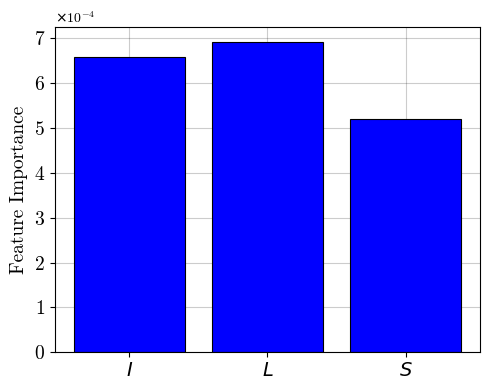

In [5]:
%%time
model = sm
X = X_tr

feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X,
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

CPU times: user 229 ms, sys: 5.95 ms, total: 235 ms
Wall time: 196 ms


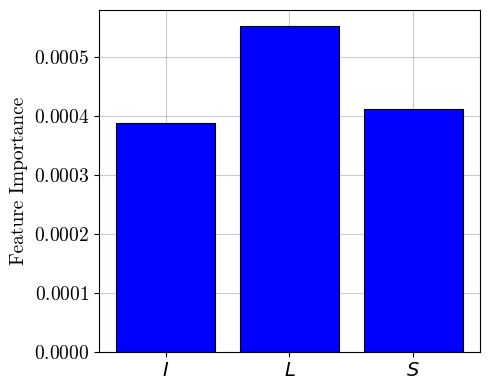

In [6]:
%%time
model = sm
X = X_tr

feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

# Feature interaction

CPU times: user 3.62 s, sys: 34.8 ms, total: 3.66 s
Wall time: 3.62 s


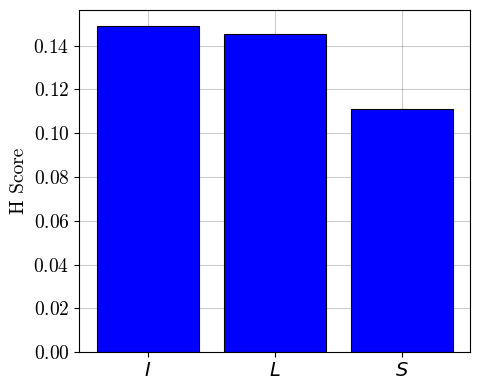

In [7]:
%%time
model = sm
X = X_tr

overall_pd_interaction = PDFeatureInteractionDisplay.overall_interaction(
    model,
    X,
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names, 
)

CPU times: user 4.06 s, sys: 64.3 ms, total: 4.13 s
Wall time: 4.19 s


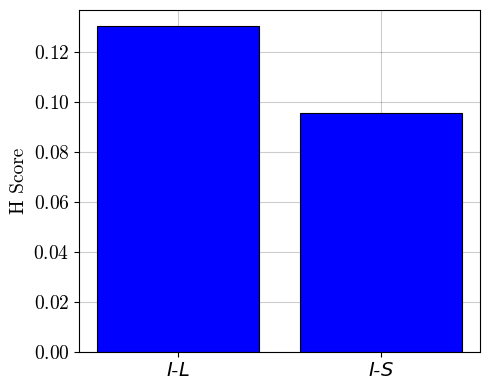

In [10]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]
feature_i = 0
feature_pairs = [
    (feature_i, feature_j) for feature_j in features if feature_j != feature_i
]

pairwise_pd_interaction = PDFeatureInteractionDisplay.pairwise_interaction(
    model,
    X,
    feature_pairs,
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

# 1 Dimension

CPU times: user 87.1 ms, sys: 2.67 ms, total: 89.7 ms
Wall time: 88.5 ms


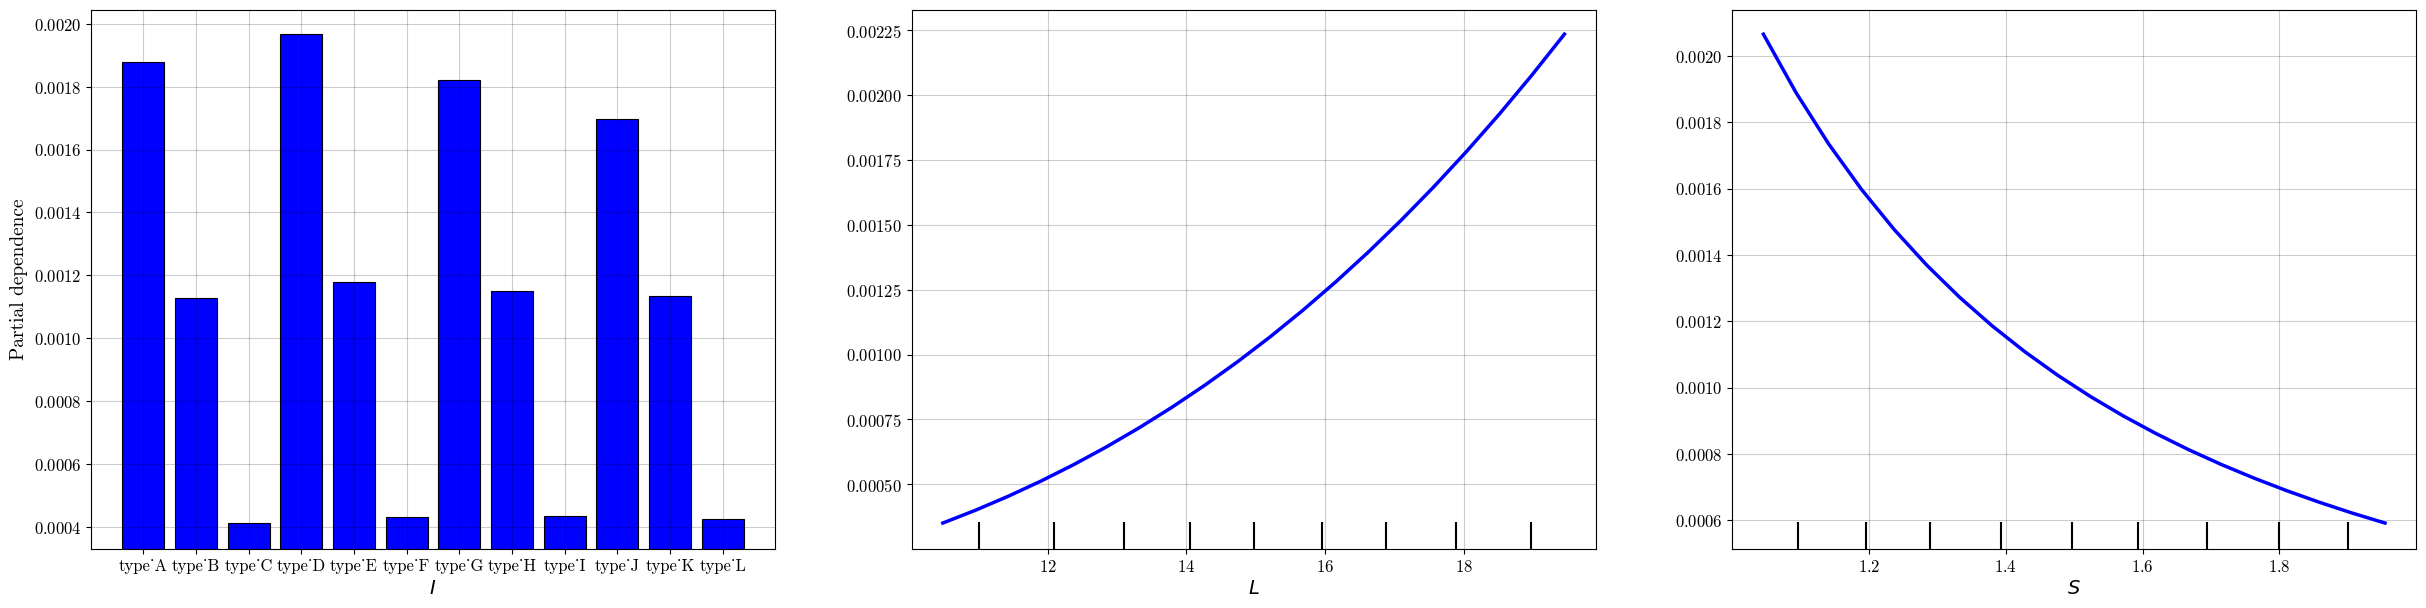

In [8]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='average',
    centered=False,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 135 ms, sys: 11 ms, total: 146 ms
Wall time: 144 ms


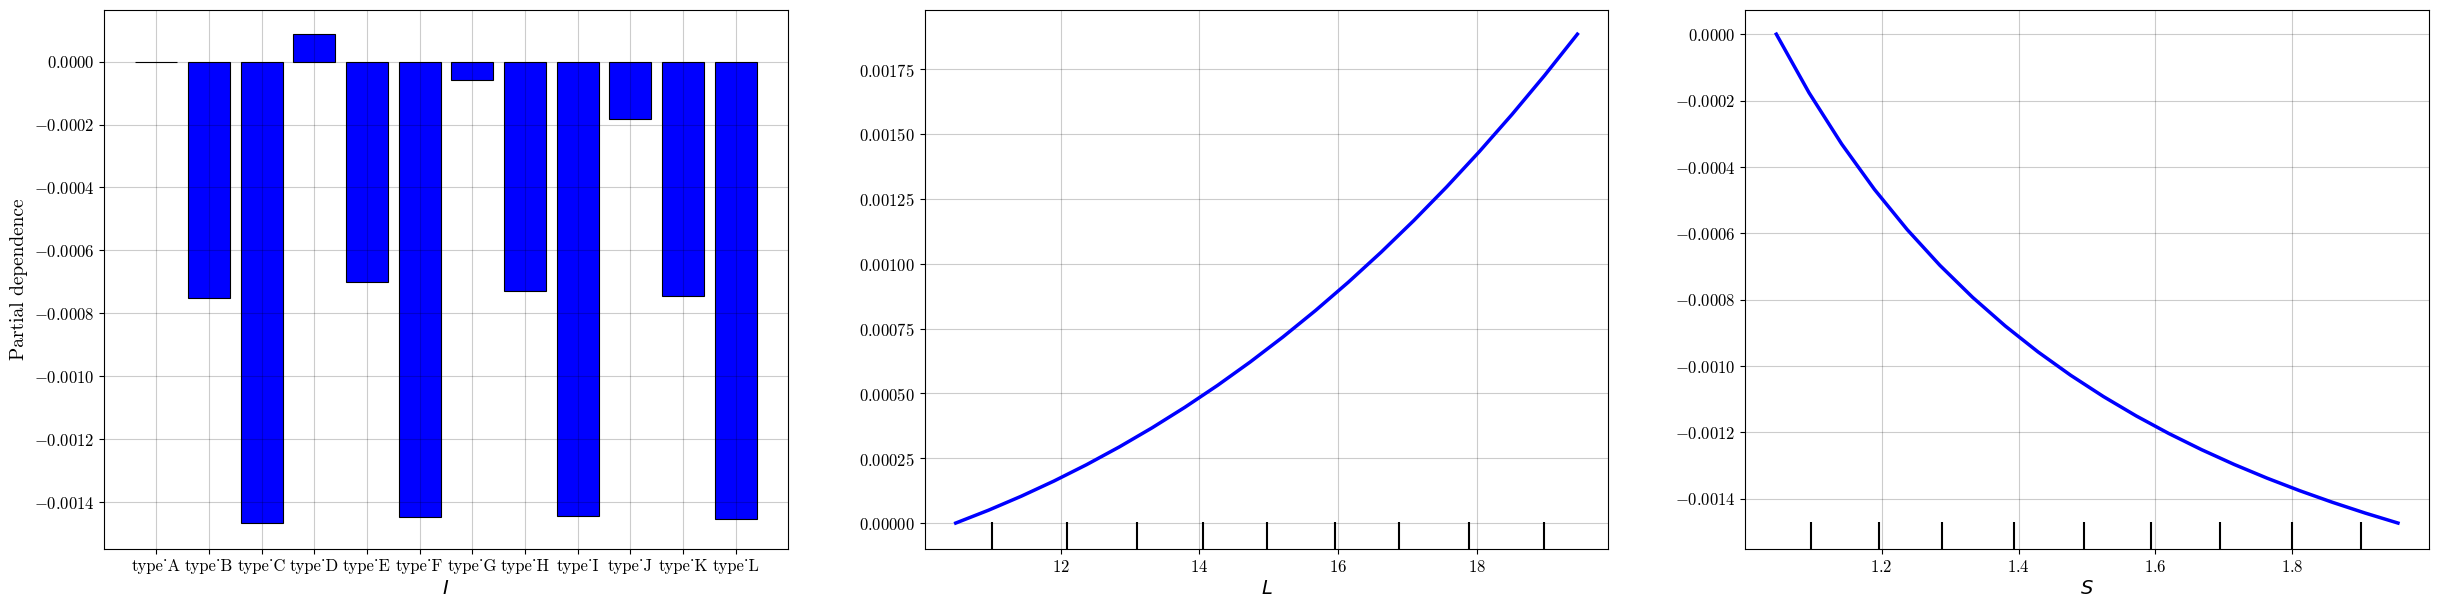

In [9]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='average',
    centered=True,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 218 ms, sys: 7.07 ms, total: 225 ms
Wall time: 228 ms


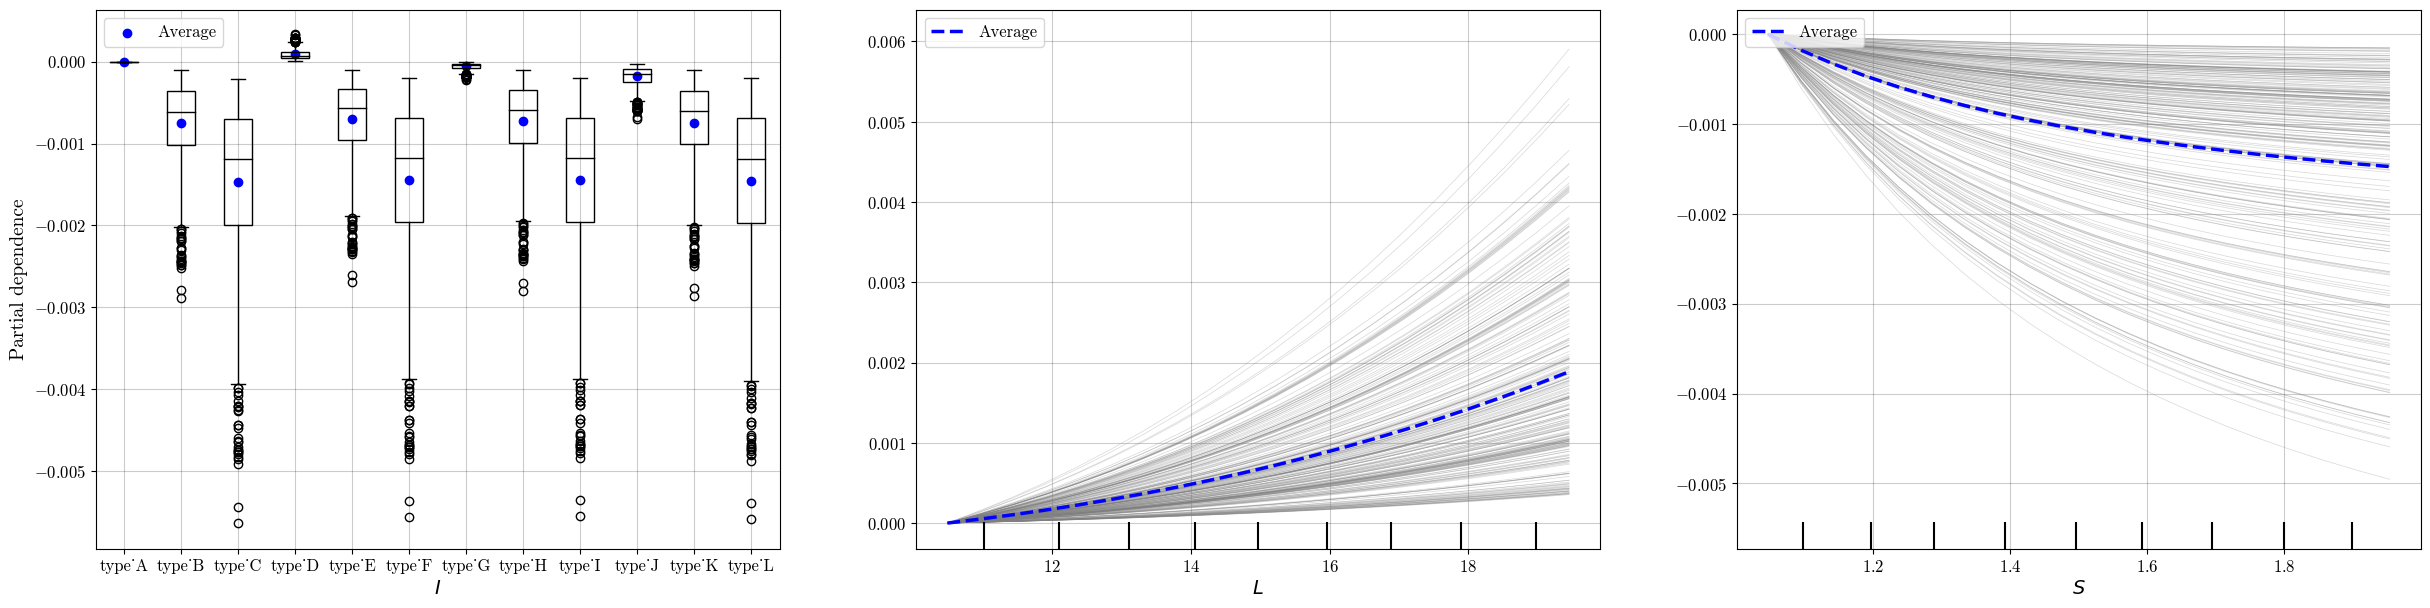

In [10]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=True,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

In [11]:
%%time
instances = X_tr
model = sm
X = X_tr

explainer_train = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X_tr, 
    feature_names=feature_names,
    categorical_features=categorical_feature_idx,
    categories_map=categories_map,
)

CPU times: user 1.17 s, sys: 19.2 ms, total: 1.19 s
Wall time: 400 ms


CPU times: user 575 ms, sys: 19 ms, total: 594 ms
Wall time: 242 ms


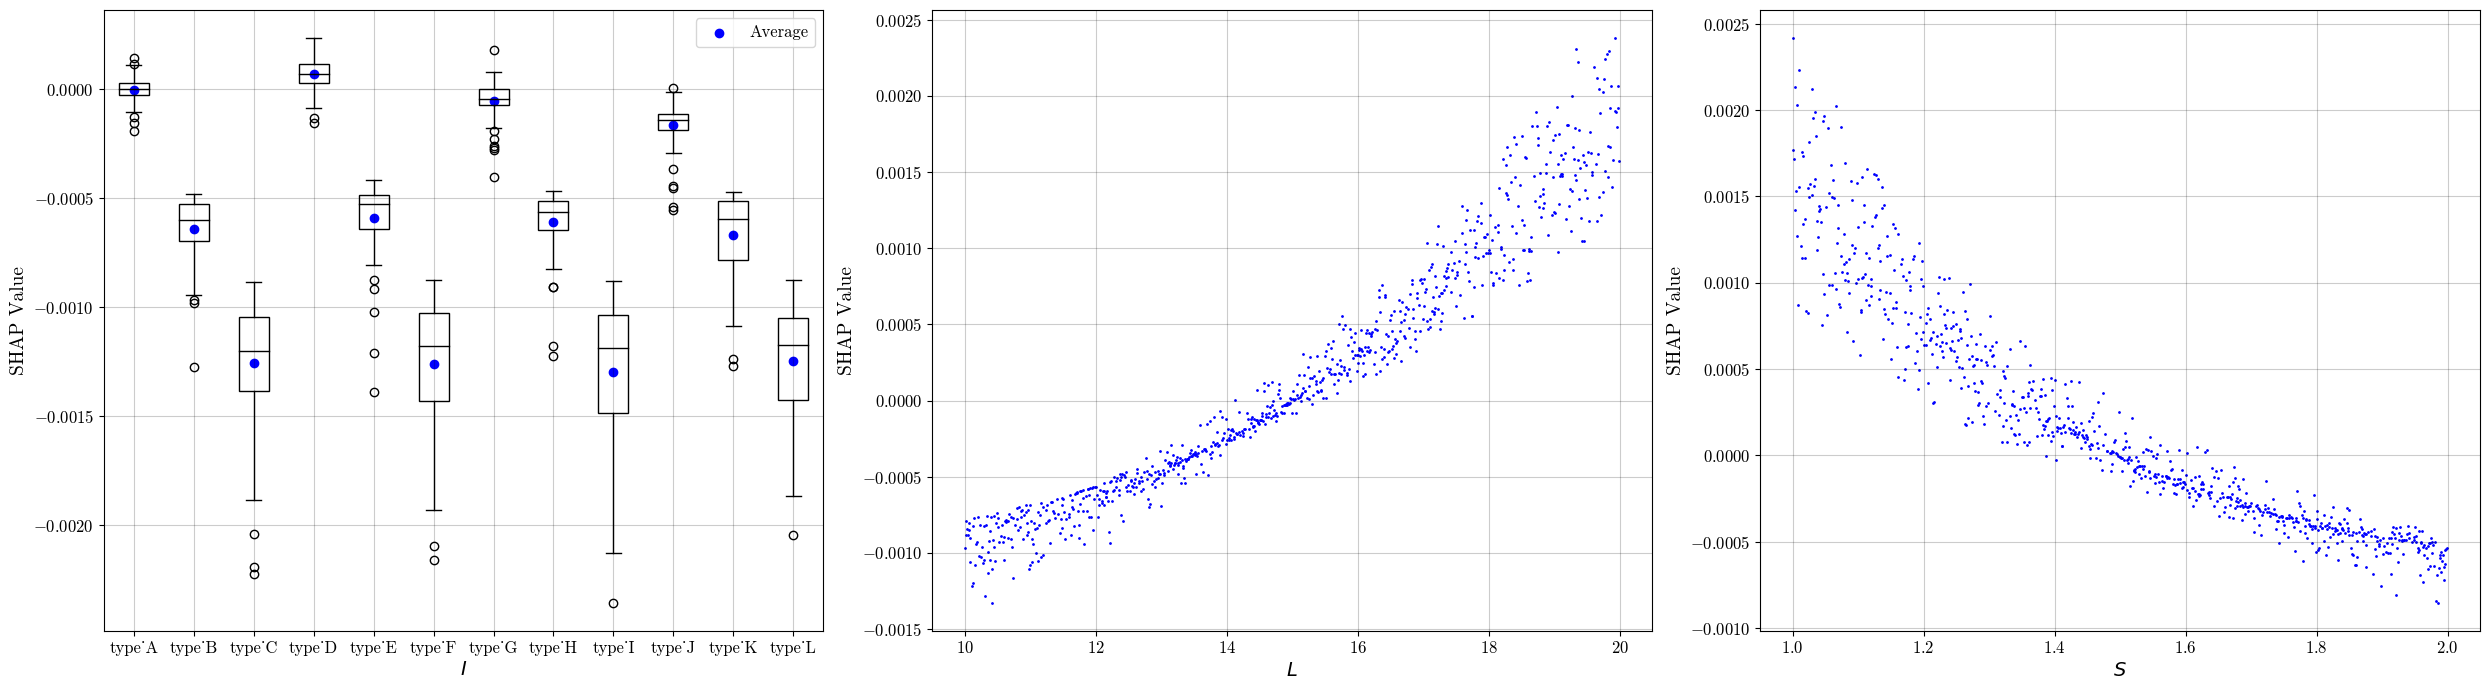

In [12]:
%%time
features = [0, 1, 2]

explainer_train.dependence_plot(
    features, 
    sort_based_on_importance=False,
    figsize=[25, 7],
)
# change reference of S to non zero

# 2 Dimension

CPU times: user 537 ms, sys: 6.33 ms, total: 543 ms
Wall time: 541 ms


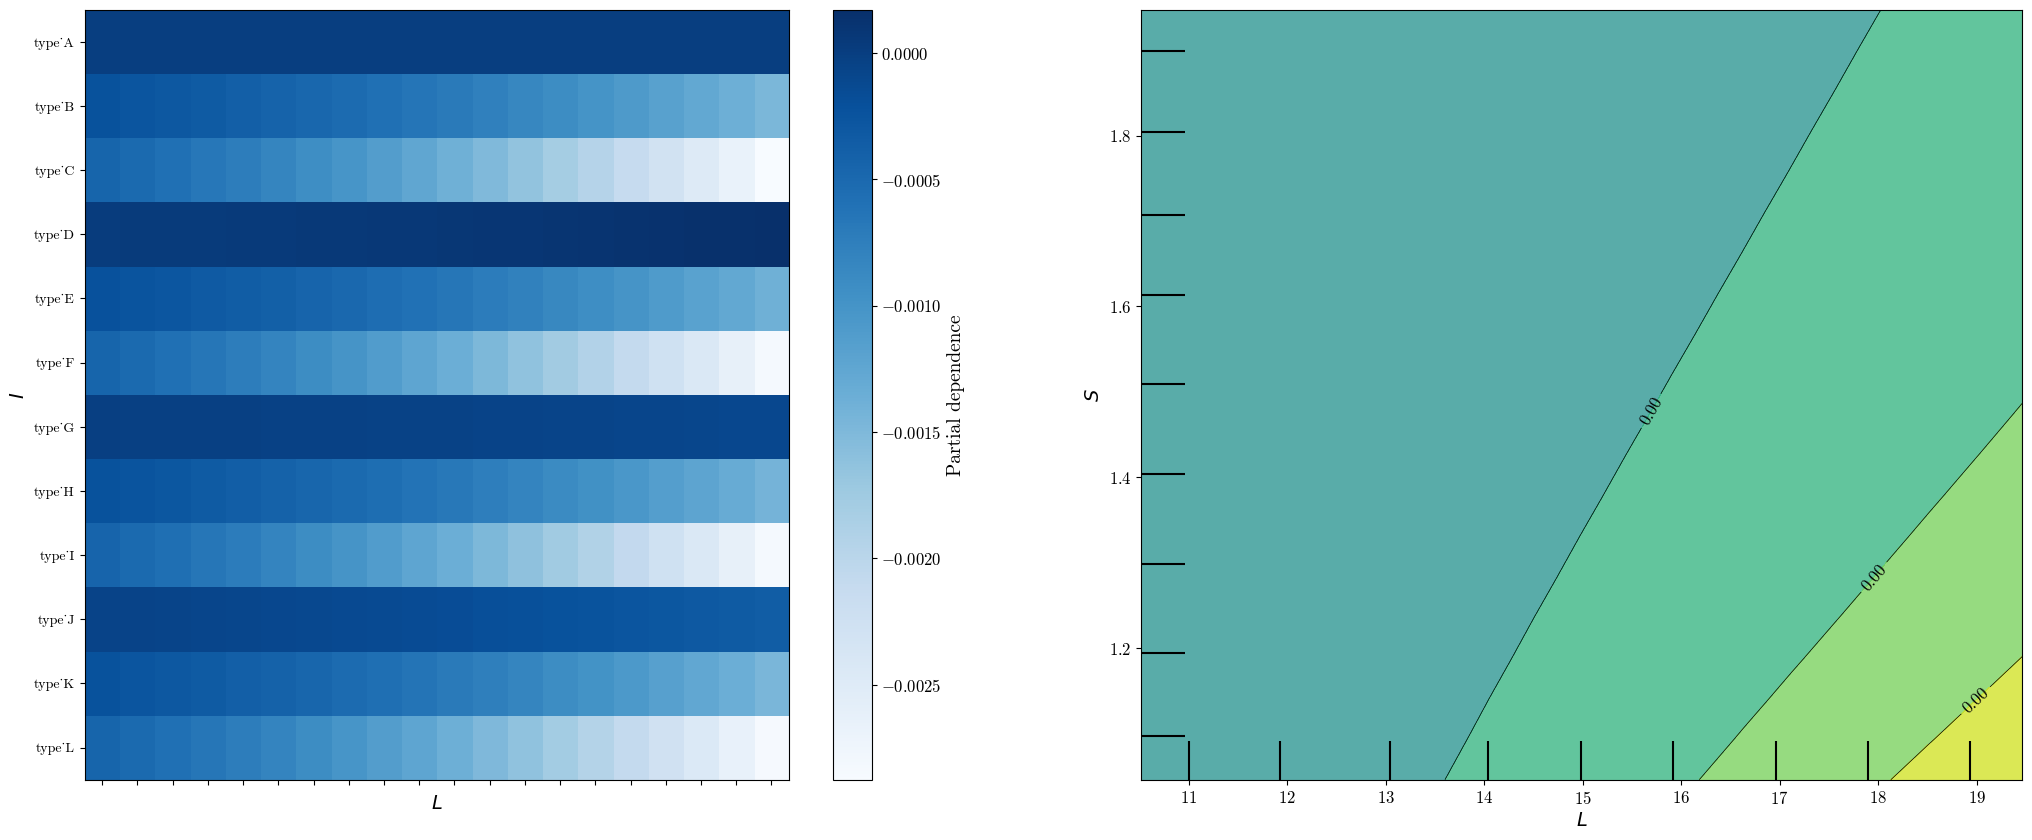

In [16]:
%%time
model = sm
X = X_tr
features = [(0, 1), (1, 2,)]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=True,
    figsize=[25, 10],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 271 ms, sys: 5.52 ms, total: 276 ms
Wall time: 123 ms


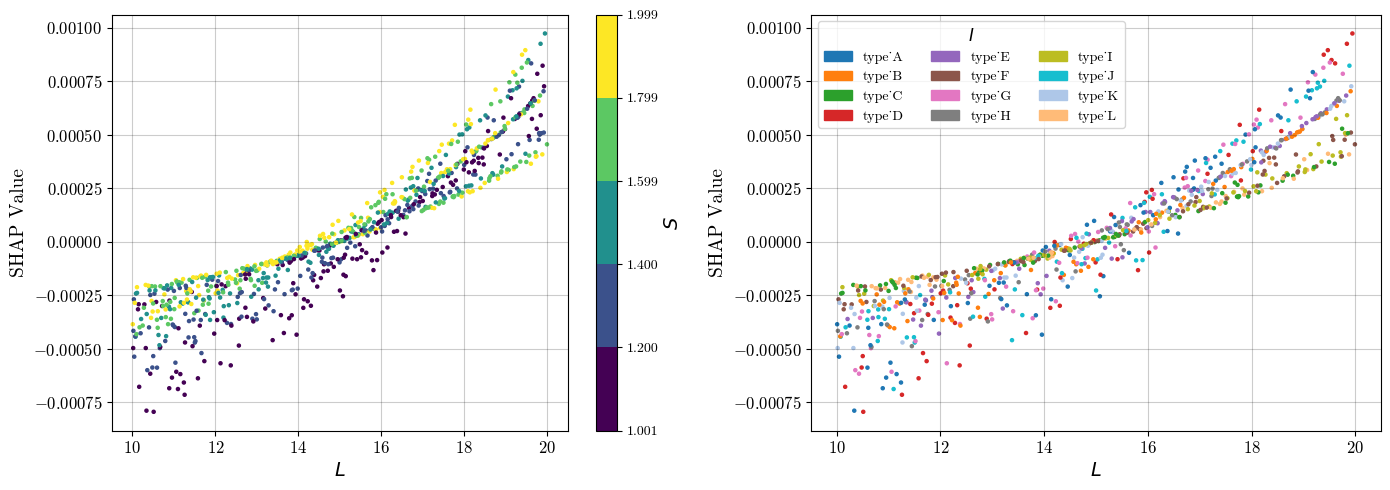

In [17]:
%%time
feature_pairs = [(1, 2), (1, 0)]
explainer_train.interaction_plot(
    feature_pairs, 
    n_color=5,
    sort_based_on_importance=False,
)

CPU times: user 173 ms, sys: 3.94 ms, total: 177 ms
Wall time: 81.9 ms


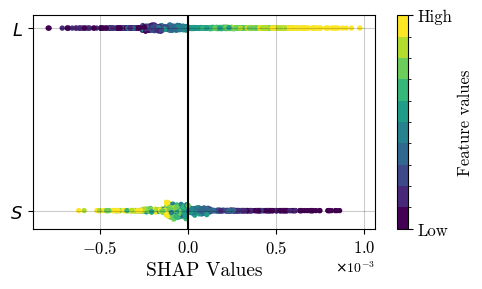

In [18]:
%%time
explainer_train.summary_plot(figsize=(5, 3), n_color=10)